In [1]:
##
## AlexNet analog (Krizhevsky 2012)
##
## 2017-05-20
## maximum on LB => 0.84500
##
## TIF - (,,6) (,,3)
##
## 2017-07-06
##  TIF (64,64,6) - полная схема без выемки 09(cloudy) - то есть 17 признаков
##  
## 2017-07-06
##  общая оценка не дает выше fpred на train 0.81-0.84
##  Поэтому проверяется идея раздельного подсчета для признаков (пачками), например 0-4, 5-9, 10-14, 15-16. 
##  Полученные результаты будут склеены и обработаны для результата.
##  Предварительная оценка fpred = 0.9 на подмножестве 0-4, существенное улучшение попаданий для набора 64x64x6.
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [6]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
#del(trOX); del(trOY);

In [15]:
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy',trX)
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy',trY)

In [16]:
if False :
    ###trXX = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy')
    ###trYY = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    trXX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trYY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')

    trX, trY = trXX[trYY[:,9]==0], trYY[trYY[:,9]==0] # not cloudy == 9 feature
    trY=trY[:,range(0,9)+range(10,17)] # --cloudy <> 9
    del trXX,trYY
    #print(trXX.shape,trYY.shape)
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX-short.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY-short.npy')
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy')
    print(trX.shape,trY.shape)
    
if True :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX-tif.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY-tif.npy')
    print(trX.shape,trY.shape)

(40479, 64, 64, 6) (40479, 17)


In [17]:
print(trX.shape,trY.shape)
###del trX, trY

(40479, 64, 64, 6) (40479, 17)


In [18]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [19]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
#
def Kriz2012 ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
#
def Kriz2012X ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    #model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(Convolution2D(128,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    #model.add(Dense(4096,activation='relu'))
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.25))
    #model.add(Dense(4096,activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [20]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
# cut version
#
#
def Kriz2012x3x3 ( model, iSize, rSize, cv2d, dense, pp ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(axis=3,input_shape=(i1,i2,i3)))
    
    if not (cv2d is None) :
        for cv in cv2d :
            if (cv>0) :
                model.add(Convolution2D(cv,(2,2)))
                #model.add(BatchNormalization(axis=3))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.25))

    model.add(Flatten())
    
    if not (dense is None) :
        for de in dense :
            if (de>0) :
                model.add(Dense(pp[5],activation='relu'))
                model.add(Dropout(0.5))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [21]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense,pp=params)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

def buildModelKriz (iSize,rSize) :
    model = Sequential()
    model = Kriz2012(model,iSize,rSize)
    
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    sgd = keras.optimizers.SGD(nesterov=True)
    
    #model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
    #              optimizer="sgd", #sgd, #"adam", #'rmsprop',
    #              metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    
    model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
                  optimizer="sgd", #sgd, #"adam", #'rmsprop',
                  metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [22]:
def gpu_memory():
    out = os.popen("nvidia-smi").read()
    ret = '0MiB'
    for item in out.split("\n"):
        if str(os.getpid()) in item and 'python' in item:
            ret = item.strip().split(' ')[-2]
    return float(ret[:-3])

gpu_mem = []
gpu_mem.append(gpu_memory())

In [23]:
modelFiles = ['../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=0-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=1-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=2-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=3-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=4-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=5-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=6-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=7-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=8-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=9-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=10-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=11-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=12-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=13-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=14-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=15-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=16-64x64x6-tif.h5',
             ]

In [77]:
#
# Общие параметры
#
epochs     = 100
verbose    = 2
batch_size = 64
stopping   = 10

prefixTemp = 'tif-64x64x6'     
metric = 'acc'


early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.00001)

In [78]:
#
# Первичное построение, тренировка и сохрание моделей по признакам в цикле
#

##epochs     = 10

print(datetime.datetime.now())

##for fs in [range(0,5),range(5,11),range(11,17)] :
##for fs in [range(5,8),range(8,9),range(9,11),range(11,17)] :
##for fs in [range(5,8)] :
#for fs in [range(8,9)] :
#for fs in [range(6,7),range(2,3),range(3,4),range(10,11),range(4,5)] :
for fs in [[xx] for xx in [7,0,5,1,2,4,10]] :
    
    trYY = trY[:,fs]
    mf   = modelFiles[fs[0]];
    print(fs,gpu_memory(),mf)
    
    gpu_mem.append(gpu_memory())
    
    K.clear_session()
    
    if not os.path.exists(mf) :
        iSize, rSize, result = (trX.shape[1],trX.shape[2],trX.shape[3]), trYY.shape[1], []
        print(datetime.datetime.now(), '  create model',iSize,rSize)
        model10 = buildModelKriz(iSize,rSize)
    else :
        print(datetime.datetime.now(), '  re-train model')
        model10 = load_model(mf);
        
    gpu_mem.append(gpu_memory())
    
    
    #filepath="../Temp/Temp/"+prefixTemp+"-fs-"+str(fs[0])+".{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-val_fbeta_pred={val_fbeta_pred:.4f}.hdf5"
    filepath="../Temp/Temp/"+prefixTemp+"-fs-"+str(fs[0])+"-ep={epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}.hdf5"
    ##checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    #checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
    checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

    hist1  = model10.fit(trX,trYY,
                        epochs=epochs, batch_size=batch_size, 
                        validation_split=0.25, 
                        callbacks=[early_stopping,checkpoint], #,reduce_lr],
                        verbose=verbose)
    if True : #False :
        #save_model(model10,'../Data-Keras/Models/AlexTIFLoop/model-Alex-fs='+str(fs[0])+'-64x64x6-tif.h5')
        save_model(model10,'../Data-Keras/Models/AlexTIFLoop/model-Alex-fs='+str(fs[0])+'-64x64x6-tif.h5')
        model10.save_weights('../Data-Keras/Models/AlexTIFLoop/model-Alex-weights-fs='+str(fs[0])+'-64x64x6-tif.h5')
    print(datetime.datetime.now(), fs[0])
    del model10
    K.clear_session()

print(datetime.datetime.now())

2017-07-07 05:46:22.682227
[7] 5681.0 ../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=7-64x64x6-tif.h5
2017-07-07 05:46:22.740869   re-train model
Train on 30359 samples, validate on 10120 samples
Epoch 1/100
Epoch 00000: acc improved from -inf to 0.91742, saving model to ../Temp/Temp/tif-64x64x6-fs-7-ep=00-acc=0.9174-val_acc=0.8916.hdf5
44s - loss: 0.2030 - acc: 0.9174 - val_loss: 0.3589 - val_acc: 0.8916
Epoch 2/100
Epoch 00001: acc improved from 0.91742 to 0.92243, saving model to ../Temp/Temp/tif-64x64x6-fs-7-ep=01-acc=0.9224-val_acc=0.8518.hdf5
43s - loss: 0.1913 - acc: 0.9224 - val_loss: 0.3430 - val_acc: 0.8518
Epoch 3/100
Epoch 00002: acc improved from 0.92243 to 0.92869, saving model to ../Temp/Temp/tif-64x64x6-fs-7-ep=02-acc=0.9287-val_acc=0.8886.hdf5
43s - loss: 0.1762 - acc: 0.9287 - val_loss: 0.3478 - val_acc: 0.8886
Epoch 4/100
Epoch 00003: acc improved from 0.92869 to 0.93844, saving model to ../Temp/Temp/tif-64x64x6-fs-7-ep=03-acc=0.9384-val_acc=0.8765.hdf5
44s - loss: 0

In [79]:
print(gpu_memory())
#del model10
K.clear_session()
print(gpu_memory())


5681.0
5681.0


In [25]:
trX.shape, trY.shape

((40479, 64, 64, 6), (40479, 17))

In [63]:
# Процедуры для оценки результативности

def confusion_matrix (tTruth, tPredict) :
    tp  = (tTruth==tPredict)&(tTruth==1); tp=len(tp[tp])
    fn  = (tTruth==tPredict)&(tTruth==0); fn=len(fn[fn])
    tn  = (tTruth<>tPredict)&(tTruth==1); tn=len(tn[tn])
    fp  = (tTruth<>tPredict)&(tTruth==0); fp=len(fp[fp])
    return(np.array([[tp,tn],[fp,fn]]))

def getConfusion (tGroundTrue, tPredict) :
    cList = []
    for i in range(tPredict.shape[1]) :
        #cList.append(skm.confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
        cList.append(confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(cList))

def getRocAUC (tGroundTrue, tPredict) :
    rList = []
    for i in range(tPredict.shape[1]) :
        rList.append(skm.roc_auc_score(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(rList))

In [64]:
print(confusion_matrix(np.array([0,0]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,1]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,1]),np.array([1,1])).tolist(),
      confusion_matrix(np.array([1,0]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,0]),np.array([0,1])).tolist()
      )

[[0, 0], [1, 1]] [[1, 1], [0, 0]] [[2, 0], [0, 0]] [[1, 0], [0, 1]] [[0, 1], [1, 0]]


In [65]:
def getProb01 (trYP, th=0.5) :
    trYY = trYP.copy()
    trYY[trYY<th] = 0
    trYY[trYY>0]  = 1
    return (trYY)

In [66]:
# Построение пределов прохождения для предсказанного
def getTh (tGround,tPredict, prec=100 ) :
    ixx,iacc = [], []
    for i in range(tGround.shape[1]) :
        max, maxxx = 0.0, 0.0
        for xx in range(0,prec+1) :
            tempYP = getProb01(tPredict[:,i],th=(float(xx)/prec)); #print(tPredict[:,1],tempYP[0])
            temp = skm.accuracy_score(tGround[:,i],tempYP)
            #print(float(xx/10.0),temp)
            if (temp>max) : 
                max = temp; maxxx = float(xx)
                temp = skm.confusion_matrix(tGround[:,i],tempYP);
                minloss = temp[0][1]+temp[1][0]
        ixx.append(maxxx)
        tempYP = getProb01 (tPredict[:,i])
        temp = skm.accuracy_score(tGround[:,i],tempYP)
        minloss05 = skm.confusion_matrix(tGround[:,i],tempYP);
        minloss05 = minloss05[0][1]+minloss05[1][0]
        iacc.append((maxxx,max,temp,minloss,minloss05))
    ixx = [float(xx/prec) for xx in ixx]
    return (ixx,iacc)
##ixx, iacc = getTh(trY,trP, prec=100)
#np.array(ixx) , iacc

In [67]:
# Посчитать уровень прохождения для каждого признака
#ixx, iacc = getTh(trY,trPr)
#np.array(ixx), iacc

In [68]:
#
# Оценка результативности предсказания
#
# Выдача массива:
#   номер поля
#   accuracy
#   roc_auc
#   tt, nn        <-- должно быть
#   tp,fn,(fp+tn) <-- получили
#
#
def estimateResult (tThruth, tPredict) :
    res = [];
    for i in range(tThruth.shape[1]) :
        cm = confusion_matrix(tThruth[:,i],tPredict[:,i])
        print('{} acc={} roc={} not={} yes={} no={} true={} all-1-0=({:.4f}-{:.4f})'.format(i,
                  skm.accuracy_score(tThruth[:,i],tPredict[:,i]),
                  skm.roc_auc_score(tThruth[:,i],tPredict[:,i]),
                  cm[0,1]+cm[1,0],
                  cm[0,0],cm[1,1],
                  cm[0,0]+cm[1,1],
                  float(cm[0,0])/len(tThruth[tThruth[:,i]==1,i]),
                  float(cm[1,1])/len(tThruth[tThruth[:,i]==0,i]),
                 ));
        res.append ((i,tThruth.shape[0],
                    skm.accuracy_score(tThruth[:,i],tPredict[:,i]),
                    #skm.accuracy_score(tThruth[:,i],tPredict[:,i]),
                    skm.roc_auc_score(tThruth[:,i],tPredict[:,i]),
                    len(tThruth[tThruth[:,i]==1]), len(tThruth[tThruth[:,i]==0]),
                    cm[0,0], cm[1,1],cm[0,1]+cm[1,0]))
    return(np.array(res))

In [69]:
def buildResult( trX, modelFileNames, batch_size=batch_size, debugOK=False ) :
    i, tResult = 0, np.zeros((trX.shape[0],len(modelFileNames)))
    if debugOK : print(tResult.shape)
    K.clear_session()
    for mf in modelFileNames :
        gpu_mem.append(gpu_memory())
        #model11  = Sequential();
        model11  = load_model(mf);
        gpu_mem.append(gpu_memory())
        tPredict = model11.predict(trX, batch_size=batch_size)
        if debugOK : print(i,tPredict.shape,tPredict[0:2].tolist())
        tResult[:,i] = tPredict[:,0]; i+=1;
        gpu_mem.append(gpu_memory())
        del model11
        K.clear_session()
    return(tResult)

In [70]:
#modelFiles[6]
#os.listdir('../Data-Keras/Models/AlexTIFLoop')

In [53]:
trPr6 = buildResult(trX,[modelFiles[x] for x in [6,2,3,10,4]],debugOK=True)

(40479, 5)
0 (40479, 1) [[4.296179523244348e-10], [1.3060812307230663e-06]]
1 (40479, 1) [[8.165154213202186e-06], [0.9984956979751587]]
2 (40479, 1) [[0.028990022838115692], [0.9996730089187622]]
3 (40479, 1) [[4.5401813508760824e-07], [0.0010756268166005611]]
4 (40479, 1) [[5.0729740905808285e-05], [0.2007431834936142]]


In [80]:
gpu_mem = []
#trPr0 = buildResult(trX,modelFiles[:11],debugOK=True)
#trPr1 = buildResult(trX,modelFiles[11:],debugOK=True)
trPr   = buildResult(trX,modelFiles,debugOK=True)

(40479, 17)
0 (40479, 1) [[0.9536657333374023], [6.853271372619929e-08]]
1 (40479, 1) [[0.9999128580093384], [0.999998927116394]]
2 (40479, 1) [[6.3901838430935245e-15], [0.999923825263977]]
3 (40479, 1) [[0.00030799079104326665], [0.9999995231628418]]
4 (40479, 1) [[4.9221453302106255e-11], [1.0]]
5 (40479, 1) [[7.625135451187985e-19], [1.2284261856621015e-06]]
6 (40479, 1) [[4.296179523244348e-10], [1.3060812307230663e-06]]
7 (40479, 1) [[3.312323144655238e-07], [0.06876268982887268]]
8 (40479, 1) [[0.002893867902457714], [0.002404022729024291]]
9 (40479, 1) [[2.2930373688723193e-06], [3.9519648664665397e-10]]
10 (40479, 1) [[5.0150147923311295e-11], [1.3324468284281465e-07]]
11 (40479, 1) [[0.0009171902202069759], [0.0003365739539731294]]
12 (40479, 1) [[0.009089146740734577], [0.011230383068323135]]
13 (40479, 1) [[0.0006949389935471117], [0.00035291718086227775]]
14 (40479, 1) [[0.00403339508920908], [8.396008342970163e-05]]
15 (40479, 1) [[0.003592813853174448], [0.00411265296861

In [81]:
#gpu_mem

In [82]:
#gpu_mem
#trPr = np.hstack([trPr0,trPr1])
np.save('../Data-Keras/Datas/train-model-2D-64x64x6-PP-tif.npy',trPr)
trPr.shape

(40479, 17)

In [73]:
#getProb01(trPr[0:10]),trY[0:10]
#del model10

In [83]:
getProb01(trPr[0:2]), trY[0:2]

(array([[ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]]),
 array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [84]:
fres = estimateResult(trY,getProb01(trPr))

0 acc=0.969144494676 roc=0.813035178277 not=1249 yes=1707 no=37523 true=39230 all-1-0=(0.6329-0.9931)
1 acc=0.977123940809 roc=0.930370917134 not=926 yes=36956 no=2597 true=39553 all-1-0=(0.9852-0.8756)
2 acc=0.942068726994 roc=0.909428995231 not=2345 yes=10173 no=27961 true=38134 all-1-0=(0.8261-0.9928)
3 acc=0.979594357568 roc=0.970742439128 not=826 yes=28221 no=11432 true=39653 all-1-0=(0.9926-0.9489)
4 acc=0.979347315892 roc=0.954328473948 not=836 yes=6780 no=32863 true=39643 all-1-0=(0.9149-0.9938)
5 acc=0.977963882507 roc=0.902133331463 not=892 yes=2963 no=36624 true=39587 all-1-0=(0.8096-0.9947)
6 acc=0.97875441587 roc=0.96286593509 not=860 yes=7558 no=32061 true=39619 all-1-0=(0.9364-0.9893)
7 acc=0.963511944465 roc=0.868295685854 not=1477 yes=3340 no=35662 true=39002 all-1-0=(0.7460-0.9906)
8 acc=0.994836828973 roc=0.5 not=209 yes=0 no=40270 true=40270 all-1-0=(0.0000-1.0000)
9 acc=0.98080486178 roc=0.890523613749 not=777 yes=1650 no=38052 true=39702 all-1-0=(0.7899-0.9912)
10

In [43]:
print(trY.shape)
#fres = estimateResult(trYY,getProb01(trP))
fres = estimateResult(trY,getProb01(trPr))
#fresList.append(fres)
#fres.tolist()

(40479, 17)
0 acc=0.940685293609 roc=0.634240331027 not=2401 yes=757 no=37321 true=38078 all-1-0=(0.2807-0.9878)
1 acc=0.946737814669 roc=0.818654024168 not=2156 yes=36340 no=1983 true=38323 all-1-0=(0.9687-0.6686)
2 acc=0.84932928185 roc=0.812670320055 not=6099 yes=8855 no=25525 true=34380 all-1-0=(0.7190-0.9063)
3 acc=0.859680328071 roc=0.784364178823 not=5680 yes=27591 no=7208 true=34799 all-1-0=(0.9705-0.5983)
4 acc=0.885669112379 roc=0.732046930294 not=4628 yes=3629 no=32222 true=35851 all-1-0=(0.4897-0.9744)
5 acc=0.909582746609 roc=0.5 not=3660 yes=0 no=36819 true=36819 all-1-0=(0.0000-1.0000)
6 acc=0.836779564713 roc=0.68997282159 not=6607 yes=3598 no=30274 true=33872 all-1-0=(0.4458-0.9342)
7 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)
8 acc=0.994836828973 roc=0.5 not=209 yes=0 no=40270 true=40270 all-1-0=(0.0000-1.0000)
9 acc=0.965364757035 roc=0.752925718524 not=1402 yes=1078 no=37999 true=39077 all-1-0=(0.5160-0.9898)
10 acc=0.87356

In [45]:
#fres = estimateResult(trY[:,[6,2,3,10,4]],getProb01(trPr6)); fres.tolist()

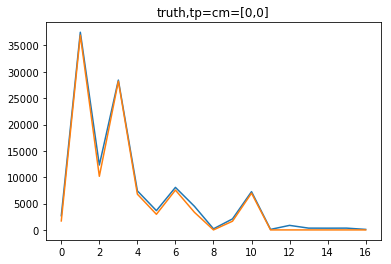

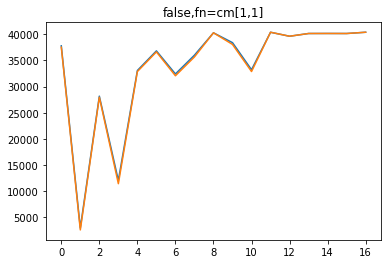

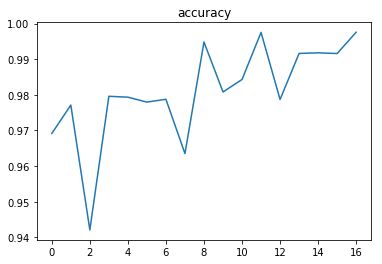

In [85]:
plt.plot([x[4] for x in fres]); 
plt.plot([x[6] for x in fres]); 
plt.title('truth,tp=cm=[0,0]')
plt.show()
plt.title('false,fn=cm[1,1]')
plt.plot([x[5] for x in fres]); 
plt.plot([x[7] for x in fres]); 
plt.show()
plt.title('accuracy')
plt.plot([x[2] for x in fres]); 
plt.show()

In [88]:
#fbeta_pred(trPr,trY)
fbeta_score(trY,trPr,beta=2)

ValueError: Can't handle mix of multilabel-indicator and continuous-multioutput

In [89]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [90]:
if True :
    trOX  = np.load('../Data-Keras/Datas/test-model-2D-64x64x6-XX-tif.npy')
    trOY  = np.load('../Data-Keras/Datas/test-model-2D-64x64x6-YY-tif.npy')
    print(trOX.shape,trOY.shape)

(61191, 64, 64, 6) (61191,)


In [91]:
trOR = buildResult(trOX,modelFiles,debugOK=True)

(61191, 17)
0 (61191, 1) [[6.361494087059327e-08], [0.006143784616142511]]
1 (61191, 1) [[1.0], [0.7227336168289185]]
2 (61191, 1) [[8.711943384580312e-13], [0.17629054188728333]]
3 (61191, 1) [[0.9999009370803833], [0.5230134725570679]]
4 (61191, 1) [[5.681400125467917e-06], [1.9985258404631168e-05]]
5 (61191, 1) [[8.288881191663433e-13], [0.004121803212910891]]
6 (61191, 1) [[7.222433100802922e-15], [0.2490975707769394]]
7 (61191, 1) [[5.145397454463241e-13], [2.4276479848595045e-07]]
8 (61191, 1) [[0.0013391522224992514], [0.0020790277048945427]]
9 (61191, 1) [[3.6290209948219854e-08], [0.0016475493321195245]]
10 (61191, 1) [[8.222192926510274e-10], [7.433099824538658e-08]]
11 (61191, 1) [[2.8465527066146024e-05], [0.01673213019967079]]
12 (61191, 1) [[0.0019435539143159986], [0.07603754848241806]]
13 (61191, 1) [[1.7223452459802502e-06], [0.05496807023882866]]
14 (61191, 1) [[0.0015949165681377053], [0.0005303684738464653]]
15 (61191, 1) [[0.0018990500830113888], [0.001644582487642

In [92]:
np.save('../Data-Keras/Datas/test-model-2D-64x64x6-RR-tif.npy',trOR)

In [95]:
#trOY = trOY.tolist()
#trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(trOR.shape,trOY.shape,trOY[0:5].tolist())

(61191, 17) (61191,) ['file_19947', 'file_19948', 'file_19949', 'file_1995', 'file_19950']


In [258]:
#Forming result

In [98]:
wr = [labels.index(i) for i in weather_labels];

trPZ = trOR
trM  = np.array([0.5]*trPZ.shape[1]);
#### Пока без коэффициентов. Коэффициенты работают +0.01 к счету trM=np.array([0.5]*17);
trM[np.array(wr)] = 2.0

res = []

for i in range(trPZ.shape[0]) :
    trA1 = [weather_labels[trPZ[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trPZ[i,ii]>trM[ii])]
    if trA1[0]=='cloudy' : trA2 = []
    ##trPP = trA1 + trA2;
    pp   = ' '.join(trA1+trA2)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])

In [101]:
print(res[0],'\n',res[-1],'\n',trM,trPZ[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  6.36149409e-08   1.00000000e+00   8.71194338e-13   9.99900937e-01
   5.68140013e-06   8.28888119e-13   7.22243310e-15   5.14539745e-13
   1.33915222e-03   3.62902099e-08   8.22219293e-10   2.84655271e-05
   1.94355391e-03   1.72234525e-06   1.59491657e-03   1.89905008e-03
   1.25100149e-03]


In [102]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [103]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-07-07-32-07
